# <font color = "brown"> Vector Auto Regression (Log Transformation) </font>

This notebook contains the Vector Auto-Regression with log transformation as time series model to predict the prices at time t+1. The vector auto-regression model is a linear combination of its lags:
$$
\begin{aligned}
\text Y_{1,t} = \alpha_{1} + \beta_{1, 1} \times Y_{1, t-1} + ... + \beta_{1, 390} \times Y_{2, t-195} + \epsilon_{1,t} \\
\text Y_{2,t} = \alpha_{1} + \beta_{2, 1} \times Y_{1, t-1} + ... + \beta_{2, 390} \times Y_{2, t-195} + \epsilon_{2,t}
\end{aligned}
$$

where $\alpha$ is the intercept, $\beta$ is the estimated parameters, $Y_{1,t}$ is the predicted price and $Y_{2,t}$ is the predicted demand. Here, we are extracting the predicted price.

Prior to fitting the data into our model, log transformation of each predictors are done by:

$$
\log(X) + |\min(X) | + 1
$$

We did not use log difference as the model is already stationary when tested using Dickey-Fuller test.

## <font color = 'brown'> Importing Libraries </font>

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.tsa.api import VAR, adfuller
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot
import warnings
import math
import seaborn as sns

# Apply the default theme
sns.set_theme()
warnings.filterwarnings("ignore") # Ignore warnings

## <font color = 'brown'> Read Data </font>

In [9]:
# Read preprocessed train and test data
training_data = pd.read_excel("../training_data.xlsx")
test_data = pd.read_excel("../testing_data.xlsx")
LAG = 195 # HQIC

In [6]:
data = pd.read_excel("../original_data.xlsx")
data = data.set_index('Time (UTC+10)')
data = data[['Regions VIC Trading Price ($/MWh)', 'Regions VIC Operational Demand (MW)']]
price = data['Regions VIC Trading Price ($/MWh)']

## <font color = "brown"> Optimal Lags using AIC, BIC, FPE, HQIC </font>

The code segment below is used to find the optimal lags using HQIC with Victoria Trading Price and Victoria Operational Demand.

In [10]:
model = VAR(dataa)

AIC = {}
BIC = {}
FPE = {}
HQIC = {}

for i in range(1,200):
    result = model.fit(i)
    try:
        AIC[i] = result.aic
        BIC[i] = result.bic
        FPE[i] = result.fpe
        HQIC[i] = result.hqic
    except:
        continue

In [11]:
min(HQIC, key = HQIC.get) # optimal lag is 195

195

## <font color = "brown"> Dickey-Fuller Test </font>

The Dickey-Fuller Test is used to check if the data of Victoria Price and Demand are stationary. To construct this test, we have:

$$
Price = Price_{t-1} + c
$$
let b = $Price_{t-1}$, the test statistic for Dickey-Fuller test is:
$$
t = \frac{(b - 1)} {se(b)}
$$
The hypothesis test is:
$$
H_0 : t = 1 \\
H_1 : t < 1
$$

The data is non-stationary if t = 1 and stationary if otherwise. Below, since all the p-values are < 0.05 (not significant), we reject $H_0$. Thus, all the data are stationary.

In [12]:
# Since p values are < 0.05, then these are significant. we reject H0

for col in data.columns:
    r = adfuller(data[col], autolag = 'aic')
    print(col)
    print('test-statistic:', r[0])
    print('p-value:', r[1])
    print('n_lags:', r[2])
    print('n_obs:', r[3])

Regions NSW Trading Price ($/MWh)
test-statistic: -25.813419063190647
p-value: 0.0
n_lags: 57
n_obs: 63399
Regions SA Trading Price ($/MWh)
test-statistic: -27.404696732796047
p-value: 0.0
n_lags: 53
n_obs: 63403
Regions TAS Trading Price ($/MWh)
test-statistic: -12.701131926267978
p-value: 1.0793175841298849e-23
n_lags: 61
n_obs: 63395
Regions VIC Trading Price ($/MWh)
test-statistic: -25.343611406634974
p-value: 0.0
n_lags: 59
n_obs: 63397
Regions NSW Trading Total Intermittent Generation (MW)
test-statistic: -22.562065979055582
p-value: 0.0
n_lags: 57
n_obs: 63399
Regions SA Trading Total Intermittent Generation (MW)
test-statistic: -23.691939845791268
p-value: 0.0
n_lags: 51
n_obs: 63405
Regions TAS Trading Total Intermittent Generation (MW)
test-statistic: -19.57372796552327
p-value: 0.0
n_lags: 50
n_obs: 63406
Regions VIC Trading Total Intermittent Generation (MW)
test-statistic: -23.08302583922224
p-value: 0.0
n_lags: 58
n_obs: 63398
Regions NSW Operational Demand (MW)
test-stat

## <font color = "brown"> Define metrics</font>

To evaluate performance, the metrics used are:
1. Dynamic Time-Wrapping (DTW)

Let t and r be two vectors of lengths m and n, respectively. The goal of DTW is to find a mapping path ${(p1,q1),(p2,q2),...,(pk,qk)}$ such that the distance on this mapping path $∑ki=1|t(pi)−r(qi)|$ is minimized.


2. Mean Absolute Percentage Error (MAPE)
$\\ \dfrac{100\%}{n}\sum\limits_{t=1}^{n}\left |\frac{e_t}{y_t}\right|$


3. Root-Mean-Square Error (RMSE)
$\\ \sqrt{\dfrac{1}{n}\sum\limits_{t=1}^{n}e_t^2}$ 


4. Mean Absolute Error (MAE)
$\\ \dfrac{1}{n}\sum\limits_{t=1}^{n}|e_t|$

where $e_t$ is $Y_{predicted} - Y_{actual}$

Primarily, we are using DTW as our metric since other metrics may not be reliable measure of time series data. These metrics are then used to compare between each predictor combinations to select the best ones.

Reference: http://mirlab.org/jang/books/dcpr/dpDtw.asp?title=8-4%20Dynamic%20Time%20Warping#:~:text=The%20distance%20between%20two%20point,n%E2%88%92yn)2.

In [28]:
# Define metrics

'''
This function takes y_true and y_pred as parameters and returns the MAPE calculated by its formula
'''
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [29]:
# Cited from https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd, https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn


'''
This function takes s as original data and t as predicted data annd returns a matrix of DTW
'''
def DTW(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

## <font color = "brown"> Define functions</font>

In [14]:
'''
This function takes df_name, min_values & names as arrays and n number of predictors and transforms each columns to their log(values)
'''
def LogTransform(df_name, min_values, name, n):
    for i in range(n):
        df_name[f'log_{name[i]}'] = np.log(df_name[name[i]] + abs(min_values[i]) + 1)
    return df_name.drop(name, axis = 1).dropna()

In [15]:
# This function finds the min values of every train and test columns

'''
FindMinValues takes:
- train and test test data as arrays 
- name as an array of predictor columns i.e. ['Time (UTC+10)', VIC Trading Price', 'VIC Demand']
- n as len(name) - 1 without 'Time (UTC+10)'
and returns the minimum values of each predictors
'''

def FindMinValues(trains, tests, name, n):
    min_values = []
    for i in range(n):
        min_val = min(trains[name[i]].min(), tests[name[i]].min())
        min_values.append(min_val)
    return min_values

In [16]:
# Preprocess data to test different predictors

'''
Preprocess takes:
- name as an array of predictor columns i.e. ['Time (UTC+10)', VIC Trading Price', 'VIC Demand']
- n as len(name) - 1 without 'Time (UTC+10)'
and returns:
- trains, tests as dataframe of log-transformed values
- train, test as arrat of log-transformed values
- minn_values as the minimum value of price
'''

def Preprocess(name, n):
    trains = training_data[name]
    tests = test_data[name]
    trains.set_index(keys = name[0], inplace = True)
    tests.set_index(keys = name[0], inplace = True)

    # Log transform these data
    names = name[1:]
    min_values = FindMinValues(trains, tests, names, n)
    trains = LogTransform(trains.copy(), min_values, names, n) # For price & demand
    tests = LogTransform(tests.copy(), min_values, names, n)

    # Rename columns
    trains.columns = names
    tests.columns = names

    # Converts to array
    train = trains.values
    test = tests.values
    
    return trains, tests, train, test, min_values

In [31]:
# Trains the model, obtain beta hat


'''
TrainModel takes:
- trains as a dataframe of log-transformed values
and returns the coefficients of beta hat of the train data
'''

def TrainModel(trains):
    model = VAR(trains)
    model_fitted = model.fit(LAG)
    # Determines beta hat for Regions VIC Trading Price
    coef = model_fitted.params
    coef2 = coef['Regions VIC Trading Price ($/MWh)']
    return coef2

In [32]:
# Predicts data


'''
PredictModel takes:
- train as an array of train values
- coef2 as the beta hat of trained data
and returns predicted price of test data
'''

def PredictModel(train, coef2):
    history = train[len(train)-LAG:]
    history = [history[i] for i in range(len(history))]
    predictions = list()

    # Calculates y_hat by multiplying beta hat with the previous (lags) of prices and demands
    for t in range(len(tests)):
        length = len(history)
        lag = np.array([history[i] for i in range(length-LAG,length)][::-1]).flatten()  # the price & demand predictors
        newyhat = np.dot(lag, coef2[1:]) + coef2[0] 
        obs = test[t]
        predictions.append(newyhat)
        history.append(obs)
    
    # Transform back to price
    tess = [i[0] for i in test]
    tess = (np.exp(tess) - abs(min_price) - 1)
    predictions = (np.exp(predictions) - abs(min_price) - 1)
    
    # Print metrics
    rmse = np.sqrt(mean_squared_error(tess, predictions))
    print('RMSE: %.3f' % rmse) # RMSE
    print('MAE: {:.3f}'.format(mean_absolute_error(tess, predictions))) # MAE
    print('MAPE: {:.3f}'.format(MAPE(tess, predictions))) #MAPE
    print(DTW(tess, predictions)) #DTW
    return predictions

In [19]:
'''
PlotPredictiosn takes:
- tests as a dataframe of actual price in the testing period
- preds as a dataframe of predicted price in the testing period
and makes a lineplot between the prices vs predicted prices
'''

def PlotPredictions(tests, preds):
    # Converts tests to original 
    tests = (np.exp(tests) - abs(min_price) - 1)

    # Plot actual vs predicted price
    expected = pd.DataFrame(tests, index=tests.index, columns=tests.columns)
    forecast = pd.DataFrame(preds, index=tests.index)
    dataframe = pd.concat([ expected["Regions VIC Trading Price ($/MWh)"],forecast[0]], axis=1)
    dataframe.index = pd.to_datetime(dataframe.index)
    dataframe.columns = ['Actual Price', 'Predicted Price']
    dataframe.plot(figsize = (16, 8), title = 'VIC Trading Price & Operational Demand', ylabel = 'VIC Trading Price ($/MWh)')

<u>Instruction:</u>
1. To predict prices of test data, run this code until the line where it saves to excel
2. Here, we are predicting using several combinations of columns and chose the best one

## <font color = "brown"> Price Predictions based on VIC Trading Price & VIC Operational Demand (Log Transformation) </font>

In [33]:
# Define train and test data
name = ["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions VIC Operational Demand (MW)"]
n = 2
trains, tests, train, test, min_values = Preprocess(name, n)

min_price = min_values[0]

In [34]:
coef = TrainModel(trains)

In [35]:
preds = PredictModel(train, coef)

RMSE: 60.871
MAE: 22.415
MAPE: 122.659
[[0.00000000e+00            inf            inf ...            inf
             inf            inf]
 [           inf 4.46087080e+01 7.07027321e+01 ... 1.26249570e+05
  1.26298816e+05 1.26344348e+05]
 [           inf 7.26174159e+01 5.41027321e+01 ... 1.12625392e+05
  1.12658038e+05 1.12686970e+05]
 ...
 [           inf 1.34967939e+05 1.31606774e+05 ... 2.70797721e+04
  2.70734993e+04 2.70862180e+04]
 [           inf 1.34988740e+05 1.31646090e+05 ... 2.71047724e+04
  2.70896627e+04 2.70933780e+04]
 [           inf 1.35025912e+05 1.31701776e+05 ... 2.71461427e+04
  2.71221960e+04 2.71259114e+04]]


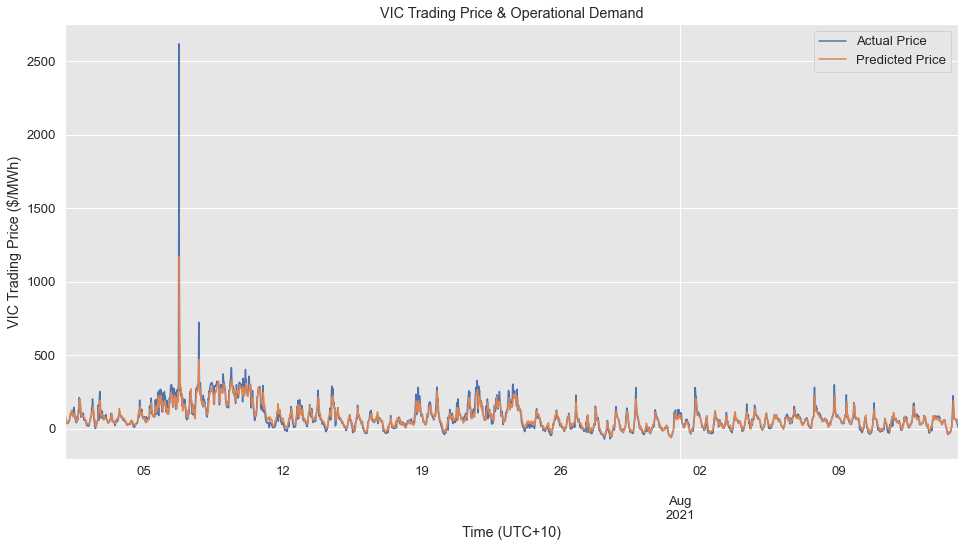

In [36]:
# Plot actual vs predicted price
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

PlotPredictions(tests, preds)

In [37]:
# Export predictions to excel
preds_df = pd.DataFrame(preds)
preds_df.index = test_data['Time (UTC+10)']
preds_df.columns = ['Predicted Price']
preds_df.to_excel("VAR_predictions_log.xlsx")

## <font color = "brown"> Price Prediction Based on VIC Trading Price & NSW Trading Demand (Log Transformation) </font>

<u>Note</u>: the code below this are for testing purposes only, in the final calculation, we are using VIC Trading Price and VIC Demand (According to Granger's Causality Test)

In [41]:
# Define train and test data
name = ["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions NSW Trading Price ($/MWh)"]
n = 2
trains, tests, train, test, min_values = Preprocess(name, n)

min_price = min_values[0]

In [42]:
coef2 = TrainModel(trains)

In [43]:
preds = PredictModel(train, coef2)

RMSE: 63.151
MAE: 23.985
MAPE: 132.442
[[0.00000000e+00            inf            inf ...            inf
             inf            inf]
 [           inf 3.66666154e+01 4.55877579e+01 ... 1.30758614e+05
  1.30802408e+05 1.30857756e+05]
 [           inf 5.67332308e+01 4.43454730e+01 ... 1.17143689e+05
  1.17170883e+05 1.17209631e+05]
 ...
 [           inf 1.32368632e+05 1.32357565e+05 ... 2.81381256e+04
  2.81254856e+04 2.81283879e+04]
 [           inf 1.32397376e+05 1.32414054e+05 ... 2.81683750e+04
  2.81471017e+04 2.81355479e+04]
 [           inf 1.32442489e+05 1.32470235e+05 ... 2.82085197e+04
  2.81850878e+04 2.81619803e+04]]


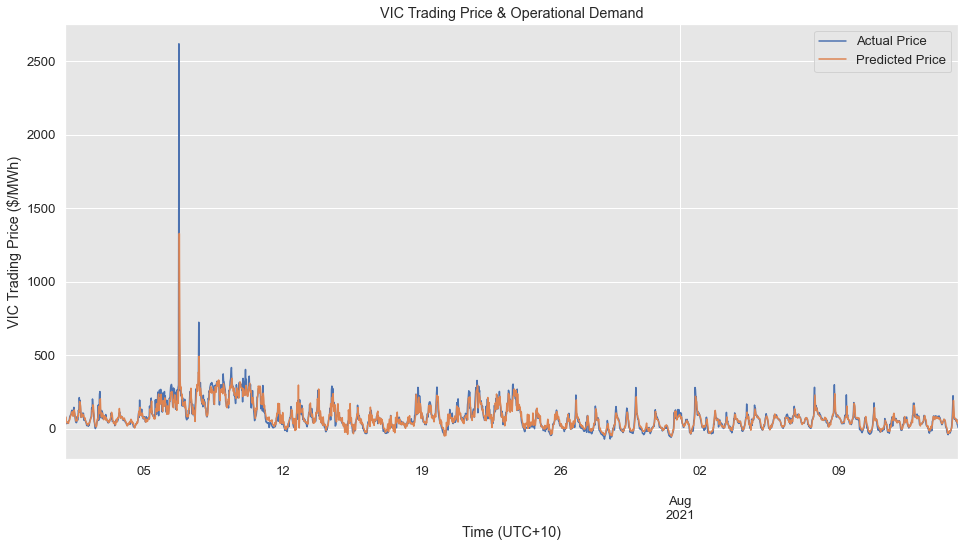

In [44]:
PlotPredictions(tests, preds)

## <font color = "brown"> Price Prediction based on VIC Trading Price, Regions VIC Operational Demand & Regions NSW Trading Price (Log Transformation)</font>

In [45]:
# Define train and test data
name = ["Time (UTC+10)","Regions VIC Trading Price ($/MWh)","Regions VIC Operational Demand (MW)", "Regions NSW Trading Price ($/MWh)"]
n = 3
trains, tests, train, test, min_values = Preprocess(name, n)

min_price = min_values[0]

In [46]:
coef3 = TrainModel(trains)

In [47]:
preds = PredictModel(train, coef3)

RMSE: 62.223
MAE: 23.889
MAPE: 138.617
[[0.00000000e+00            inf            inf ...            inf
             inf            inf]
 [           inf 4.34404340e+01 6.06612811e+01 ... 1.29805946e+05
  1.29852608e+05 1.29898637e+05]
 [           inf 7.02808679e+01 4.40612811e+01 ... 1.16797133e+05
  1.16827195e+05 1.16856624e+05]
 ...
 [           inf 1.34480601e+05 1.33781130e+05 ... 2.91620558e+04
  2.91531775e+04 2.91653990e+04]
 [           inf 1.34502571e+05 1.33829319e+05 ... 2.91883959e+04
  2.91719252e+04 2.91725590e+04]
 [           inf 1.34540910e+05 1.33893879e+05 ... 2.92306703e+04
  2.92070428e+04 2.92076766e+04]]


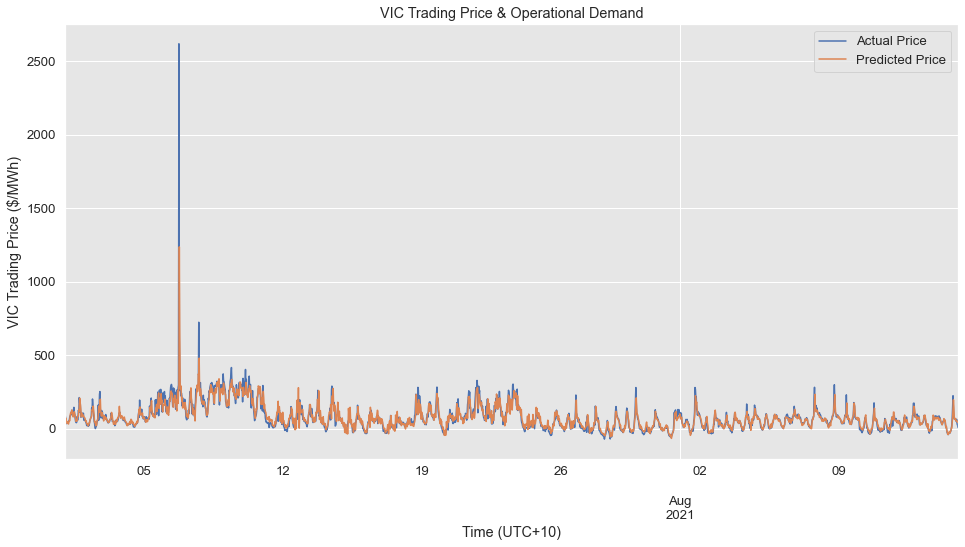

In [48]:
PlotPredictions(tests, preds)